<h1>Los et al. experiment</h1>

In [1]:
import math
import random
from model import Model
from dmchunk import Chunk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def noise(s):
    rand = random.uniform(0.001, 0.999)
    return s * math.log((1 - rand)/rand)

In [3]:
def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015):
    pulses = 0
    pulse_duration = t_0
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses += 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return pulses

In [4]:
def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015):
    time = 0
    pulse_duration = t_0
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + noise(b * a * pulse_duration)
    return time

In [5]:
# randomly choose one of the FP values (0.4, 0.8, 1.2, 1.6) and return FP and its pulse.
def random_fp():
    fp_list = [0.4, 0.8, 1.2, 1.6]
    fp = random.choice(fp_list)
    # subtracted 0.05 secs for preparation advantage as in previous assignment.
    pulse = time_to_pulses(fp-0.05)
    
    return fp, pulse

In [6]:
def experiment():
    # List to save reaction times
    rt = []
    count = 1
    
    # create the Model object
    m = Model()
    # set decay to 0.1 (default was 0.5).
    m.d = 0.1
    
    # initialize the dataframe with columns 'FP', 'FP_n-1', 'RT'.
    column_names = ['FP', 'FP_n-1', 'RT']
    df = pd.DataFrame(columns=column_names)
    
    for i in range(900):
        if i == 0:
            fp, current_pulse = random_fp()
            expectation = current_pulse
            
            # when it is the first trial, add the starting chunk to the model with randomly selected FP and its pulse
            # and append the default reaction time (0.4 secs) rt since we do not have any expectations yet.
            starting = Chunk(name = "starting", slots = {"fp": fp, "current": current_pulse})
            m.add_encounter(starting)
            m.time += 0.05
            
            rt.append(0.4)
            # append FP, FP_n-1 and RT (reaction time) to the dataframe. Since we do not have previous pulse, FP and FP_n-1
            # are the same for the convenience. It does not affect the result of the experiment since we have many trails
            # to run.
            df = df.append({'FP': fp, 'FP_n-1': fp, 'RT': rt[i]}, ignore_index = True)
        else:
            # retrieve the pulse stored in previous trial.
            query = Chunk(name = "retrieval", slots = {"fp": fp, "current": current_pulse})
            result, latency = m.retrieve(query)
            
            # expectation is the pulse stored in previous trial.
            expectation = result.slots["current"]
            # previous_fp is the fp value of the stored pulse.
            previous_fp = result.slots["fp"]
            
            m.add_encounter(result)
            m.time += latency
            
            # convert expectation to time to calculate preparation.
            expectation_time = pulses_to_time(expectation)
            # randomly select FP for this trial and return it with its pulse.
            fp, current_pulse = random_fp()
            
            # preparation is calculated as absolute value of difference between expectation_time (time of the previous pulse) 
            # and foreperiod (fp) calculated in this trial.
            preparation = abs(expectation_time - fp)
            # if expectation is before compared to foreperiod and preparation is bigger than 0.05 sec, response_time is 0.4
            # (default reaction time) - 0.05 sec.
            if expectation_time < fp:
                if preparation > 0.05:
                    response_time = 0.4 - 0.05
                # if expectation is before compared to stimulus and preparation is smaller than 0.05 sec, response_time is 0.4
                # (default reaction time) - preparation.
                else:
                    response_time = 0.4 - preparation
                rt.append(response_time)
            # if expectation is after compared to foreperiod, there is no preparation, hence response_time is 0.4
            # (default reaction time) sec.
            else:
                rt.append(0.4)
            # append FP, FP_n-1 and RT (reaction time) to the dataframe.
            df = df.append({'FP': fp, 'FP_n-1': previous_fp, 'RT': rt[i]}, ignore_index = True)
            
            # add new chunk to the model that saves FP from this trial, its pulse and pulse from the previous trial.
            new_chunk = Chunk(name = "fp" + str(count), slots = {"fp": fp, "current": current_pulse, "previous": expectation})
            m.add_encounter(new_chunk)
            m.time += 0.05
            
            count += 1

    return df

In [7]:
# run the above experiment for given number of subjects.
def trials(subjects):
    experiments = []
    for i in range(subjects):
        experiments.append(experiment())
    
    final_df = pd.concat(experiments)
    
    return final_df

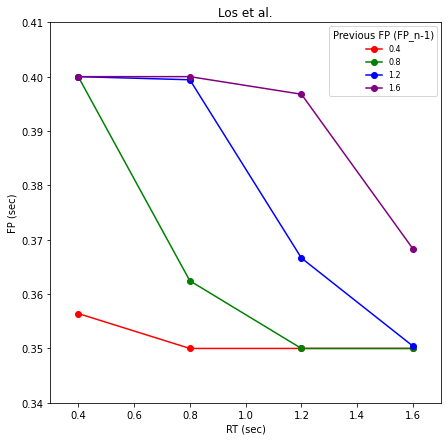

In [8]:
# run the experiment for 5 subjects. I tried 5, 10, 25 and 50, and saw that resulting graph does not change for many
# participants. Hence, I decided to use 5 subjects since I have less computation power in my computer and results do not
# change observably.
df = trials(5)

# calculate mean RT by FP_n-1
mean_rt = df.groupby(['FP_n-1', 'FP'])['RT'].mean().reset_index()

cond1 = mean_rt.loc[mean_rt['FP_n-1'] == 0.4]
cond2 = mean_rt.loc[mean_rt['FP_n-1'] == 0.8]
cond3 = mean_rt.loc[mean_rt['FP_n-1'] == 1.2]
cond4 = mean_rt.loc[mean_rt['FP_n-1'] == 1.6]

# make plot
f, ax = plt.subplots(figsize = (7,7))

ax.set(xlim = (0.3, 1.7), ylim = (0.34, 0.41))

ax.set_title('Los et al.')

ax.set_xlabel('RT (sec)')
ax.set_ylabel('FP (sec)')

ax.plot(cond1['FP'], cond1['RT'], color = 'red', marker = 'o', label = "0.4")
ax.plot(cond2['FP'], cond2['RT'], color = 'green', marker = 'o', label = "0.8")
ax.plot(cond3['FP'], cond3['RT'], color = 'blue', marker = 'o', label = "1.2")
ax.plot(cond4['FP'], cond4['RT'], color = 'purple', marker = 'o', label = "1.6")

ax.legend(title = 'Previous FP (FP_n-1)', prop={'size': 8})

### Findings

During the experiment, I realized that it is not possible to always retrieve the previous chunk. To see that how this could possible affect the resulting graph, I made a small experimentation: 

1) I use normal retrieval (I used it since Niels suggested to do so) playing with the decay parameter in ACT-R (since as you mentioned it is not possible to retrieve the previous chunk always) and 2) I stored the pulse from previous trial using list to exactly the retrieve previous pulse (since we can do it using a list). I discovered that even we are able to retrive the pulse from previous trial exactly, there were no difference at all between the graphs.

Additionally, I played with the decay value (I tried 0.001, 0.08, 0.1, 0.5 and 100). When decay is 0.001, activations fluctuate between retrieved chunks, but sometimes it fails to retrieve a chunk. When decay is 100, all the activations are identical almost for the chunks retrieved. For the other values, nothing changed between the resulting graphs. I set the value for each subject inside the experiment() as m.d = x. You can experiment yourself changing the m.d inside experiment() to see.

I believe that my resulting graph is plausible since it is somewhere between the original grap and Niels' graph. It follows the trends that are shown in both example graphs on Nestor.